In [17]:
from tensorflow.keras.preprocessing import image
from keras.models import load_model
from keras import backend
import numpy as np
import pandas as pd
import os
import random
import gc
import tensorflow as tf
import logging
from PIL import Image


In [ ]:

# 设置日志文件路径
log_file = "tensorflow_output.log"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

# 配置日志记录
logging.basicConfig(filename=log_file, level=logging.DEBUG)

# 强制 TensorFlow 使用 CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# 确保没有 GPU 被 TensorFlow 检测到
if tf.config.experimental.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("Using CPU only")

In [18]:

# 加载模型
def smooth_labels_loss(label_smoothing=0.1):
    def loss(y_true, y_pred):
        num_classes = backend.int_shape(y_pred)[-1]
        smooth = label_smoothing / num_classes
        y_true = y_true * (1 - label_smoothing) + smooth
        return backend.categorical_crossentropy(y_true, y_pred)
    return loss

model = load_model('ckpt.h5', custom_objects={'loss': smooth_labels_loss(0.001)})


1/1 [==============================] - 0s 18ms/step


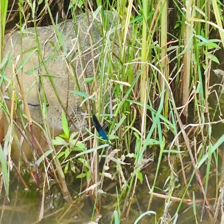

Index: 1481, Probability: 0.2281, categoryID: 2333, ScientificName: Calopteryx splendens, Common Name: Banded Demoiselle


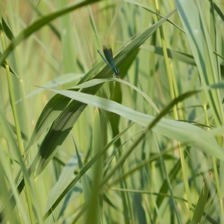

Index: 1482, Probability: 0.1972, categoryID: 2334, ScientificName: Calopteryx virgo, Common Name: Beautiful Demoiselle


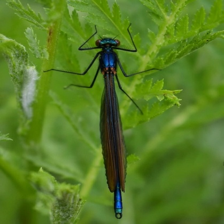

Index: 1485, Probability: 0.1149, categoryID: 2337, ScientificName: Matrona cyanoptera, Common Name: Formosan Jewelwing


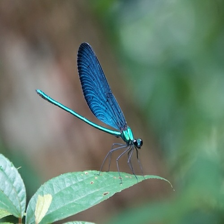

Index: 1480, Probability: 0.0734, categoryID: 2332, ScientificName: Calopteryx maculata, Common Name: Ebony Jewelwing


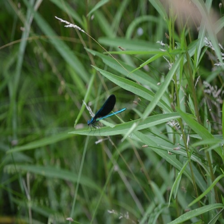

Index: 1478, Probability: 0.0351, categoryID: 2330, ScientificName: Calopteryx aequabilis, Common Name: River Jewelwing


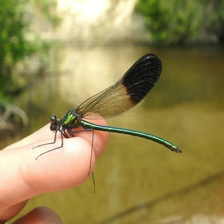

In [24]:

def predict_image(img_path):
    # 加载并预处理图片
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # 进行预测
    predictions = model.predict(img_array)
    return predictions

# 测试推理
img_path = '.\\test\\f5f93e338cfadbbb26f474b980f8f95.jpg'
predictions = predict_image(img_path)

# 获取预测结果中的前5个最高概率及其索引
top_5_indices = np.argsort(predictions[0])[-5:][::-1]
top_5_values = predictions[0][top_5_indices]

# 读取class_indices.csv和categoryMap.csv
class_indices_df = pd.read_csv('class_indices.csv', header=0, names=['categoryID', 'index'])
category_map_df = pd.read_csv('categoryMap.csv', header=0, encoding='latin1')

# 加载并预处理图片
img = Image.open(img_path)
img = img.resize((224, 224))
display(img)

for index, value in zip(top_5_indices, top_5_values):
    # 根据索引找到对应的categoryID
    category_id = class_indices_df[class_indices_df['index'] == index]['categoryID'].values[0]
    # 根据categoryID找到对应的物种名
    species_info = category_map_df[category_map_df['id'] == category_id]
    name = species_info['name'].values[0]
    common_name = species_info['common_name'].values[0]
    image_dir_name = species_info['image_dir_name'].values[0]
    image_folder_path = os.path.join('.\\train_mini\\', image_dir_name)
    image_file = random.choice(os.listdir(image_folder_path))
    val_image_path = os.path.join(image_folder_path, image_file)
    
    print(f"Index: {index}, Probability: {value:.4f}, categoryID: {category_id}, ScientificName: {name}, Common Name: {common_name}")
    img = Image.open(val_image_path)
    img = img.resize((224, 224))
    display(img)


In [23]:
print(sum(top_5_values))

0.2924254424870014


In [6]:
gc.collect()
backend.clear_session()